# **Solar Radiation Forecasting MIAR**
###Dans le cadre du Master en IA et Robotique de l'Université des Mascareignes, cette partie du projet consiste à effectuer la prévision de la radiation solaire par l'IA en utilisant des données en temps réel du station météorologique du projet ***IOS-net*** *(**I**ndian **O**cean **S**olar **net**work)* de l'ENERGY-Lab de l'Université de La Réunion installé à ***Vacoas Mauritius***. 
###Les données seront collecté en format netCDF(**net**work **C**ommon **D**ata **F**orm) à travers le serveur TDS, outil de big data supportant ce format particulier dont l'avanage est de permettre de contenir les metadata.

###**NB :** Les données du station météorologique de Vacoas sont logged journalièrement au seveur TDS à compté du *19-10-2019 jusqu'à actuelle.*

# **I- Data Collection** (Accès aux fichier netCDF sur le serveur TDS du IOS-net)


##1- Installation des packages 

In [ ]:
! pip install siphon
! pip install seaborn
! pip install numpy
! pip install matplotlib
! pip install urllib3
! pip install netCDF4


     |████████████████████████████████| 69 kB 4.6 MB/s 


##2- Importation des modules

In [ ]:
from datetime import datetime, timedelta
import os.path, os
from siphon.catalog import TDSCatalog
from urllib.error import HTTPError
import pandas as pd
# Import some visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
tds_url = 'https://galilee.univ-reunion.fr/thredds/catalog/dataStations/'

##3- Accéder au metadata
Le code ci dessous nous permet de visualiser les metada et ainsi les variables contenu dans chacun de nos fichier netCDF.

In [ ]:
tds_base_url = f'{tds_url}/catalog.xml'

# Access the TDS catalogue 
print(f'Requesting {tds_base_url} ...')
cat_base = TDSCatalog(tds_base_url)

# Get catalogue metadata
metadata = cat_base.metadata

# List the variables and their units
variables = metadata['variables']

print('Liste des variables :')

for k,v in variables.items():
    unit = v['units']
    print(f' # {k} ({unit}) ')

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations//catalog.xml ...
Liste des variables :
 # global_horizontal_irradiance (W m-2) 
 # diffuse_horizontal_irradiance (W m-2) 
 # UV_irradiance_on_A_and_B_band (W m-2) 
 # relative_humidity (%RH) 
 # air_pressure (hPA) 
 # rainfall (mm) 
 # air_temperature (degree Celsius) 
 # dew_point_temperature (degree Celsius) 
 # wind_direction  (degree) 
 # standard_deviation_of_wind_direction (degree) 
 # wind_speed (m s-1) 
 # wind_speed_max_of_gust (m s-1) 
 # minimum_datalogger_voltage (degree Celsius) 
 # thermocouple_box_temperature (degree Celsius) 
 # datalogger_intern_temperature (degree Celsius) 
 # solar_panel_back_surface_temperature (degree Celsius) 


## 3) Accéder à distance au fichier

Les données netCDF disponible sur le serveur TDS sont générer de facon à contenir chancun des fichiers journlière.

Accessible via le lien : 
https://galilee.univ-reunion.fr/thredds/catalog/dataStations/catalog.html

###a- Analyse des données premièrement disponible sur le serveur TDS

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
YEAR = 2019
MONTH = '10' # MONTH format must be a two character string : 'xx'
DAY = '29'  # DAY format must be a two character string : 'xx'

# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]

# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)

ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')


# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2019/catalog.xml ...


ConnectionError: ignored

**Commentaire du graphe : **

Comme on voit sur le graph ci dessus, les données récoltés lors debut du lancement de la station, c-à-dire du *19-10-2019*, n'est pas complète mais commence vers *18h*, donc ne nous est pas utile pour notre projet de prévision. La raison principale c'est que les données mis à part des horraires présenté sur la courbe ci dessus, de la date 19-10-2019, sont toutes **NA**.

###b- Analyse des données dernièrement disponible sur le serveur TDS

DAY : 21
MONTH : 4
Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2022/catalog.xml ...
Found 1 file(s) : [1572415339_2022-04-21.nc]
 1440 values found for variable "time" ,correspondant au données par minutes journalière 


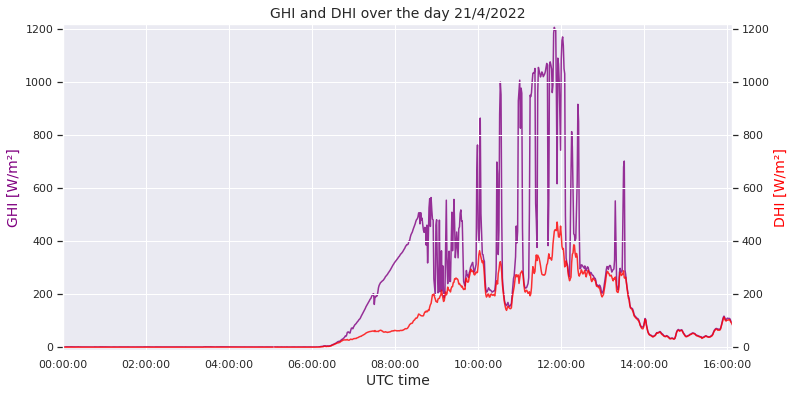

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'   
date = datetime.utcnow() 
YEAR = date.year
YEAR=2022
MONTH = date.month # MONTH format must be a two character string : 'xx'
#Get last date logged(yesterday)
lastdate = datetime.now() + timedelta(days=-1)  
DAY=str(lastdate.day)  # DAY format must be a two character string : 'xx'
print(f'DAY : {DAY}')
print(f'MONTH : {MONTH}')
#datetime.timedelta(days=1)
# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{str(YEAR)}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]  

GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]

# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)

ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')


# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
date = datetime.utcnow() 
YEAR = date.year
MONTH = date.month # MONTH format must be a two character string : 'xx'
#Now let get last date logged(yesterday date)
lastdate = datetime.now() + timedelta(days=-2)  
DAY='0'+str(lastdate.day)  # DAY format must be a two character string : 'xx'
print(f'DAY : {DAY}')
# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]
RH = data['relative_humidity'][:]
Temp = data['air_temperature'][:]
UV = data['UV_irradiance_on_A_and_B_band'][:]
P = data['air_pressure'][:]
Wind = data['wind_speed'][:]
dT = data['dew_point_temperature'][:]
# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax2.twinx()
ax4 = ax3.twinx()
ax5 = ax4.twinx()
ax6 = ax5.twinx()
ax7 = ax6.twinx()
ax8 = ax7.twinx()


ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)
ax3.plot(T_dt, RH, c='blue', alpha = 0.8)
ax4.plot(T_dt, Temp, c='black', alpha = 0.8)
ax5.plot(T_dt, UV, c='red', alpha = 0.8)
ax6.plot(T_dt, P, c='yellow', alpha = 0.8)
ax7.plot(T_dt, Wind, c='green', alpha = 0.8)
ax8.plot(T_dt, dT, c='orange', alpha = 0.8)


ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

Voici à la courbe ci dessus, un exemple d'illustration de donnée journalière complète receillit chaque minute de la journée de hier.

Ici notre variable de sortie est le GHI (global_horizontal_irradiance) en (W/m^2)
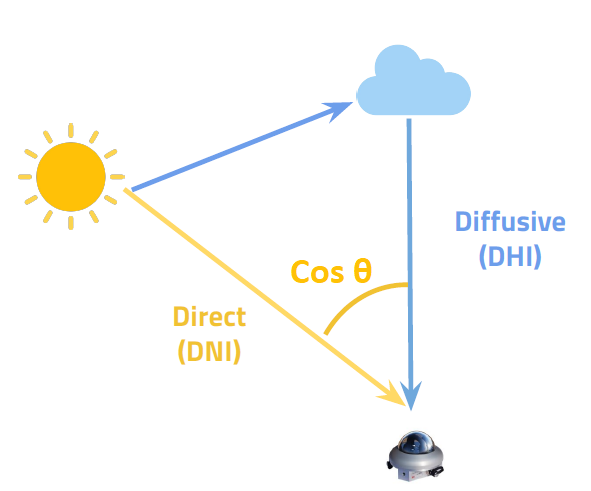


GHI = DHI + cos(𝞡) *DNI

###c- Filtrage des variables  
Ici on va choisir les variables qui peuvent avoir des reletions direct pour la prévision de l'ensoillement. C'est à dire les variables d'entrer et variable de sortie de notre LSTM.

DAY : 06
Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2022/catalog.xml ...
Found 1 file(s) : [1572415339_2022-04-06.nc]
 1440 values found for variable "time" ,correspondant au données par minutes journalière 


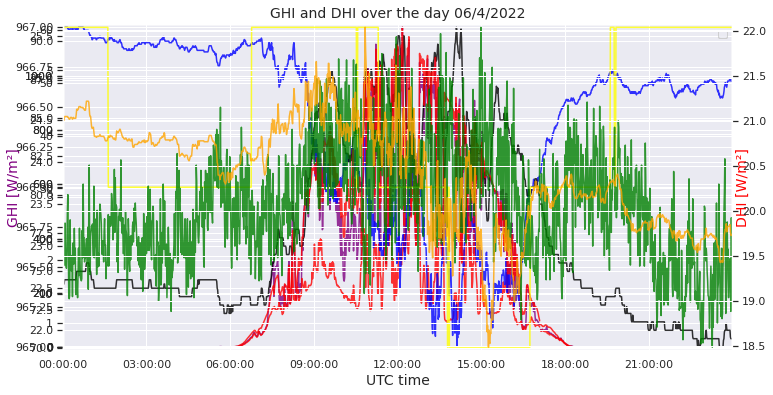

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
date = datetime.utcnow() 
YEAR = date.year
MONTH = date.month # MONTH format must be a two character string : 'xx'
#Now let get last date logged(yesterday date)
lastdate = datetime.now() + timedelta(days=-2)  
DAY='0'+str(lastdate.day)  # DAY format must be a two character string : 'xx'
print(f'DAY : {DAY}')
# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]
RH = data['relative_humidity'][:]
Temp = data['air_temperature'][:]
UV = data['UV_irradiance_on_A_and_B_band'][:]
P = data['air_pressure'][:]
Wind = data['wind_speed'][:]
dT = data['dew_point_temperature'][:]
# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax2.twinx()
ax4 = ax3.twinx()
ax5 = ax4.twinx()
ax6 = ax5.twinx()
ax7 = ax6.twinx()
ax8 = ax7.twinx()


ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)
ax3.plot(T_dt, RH, c='blue', alpha = 0.8)
ax4.plot(T_dt, Temp, c='black', alpha = 0.8)
ax5.plot(T_dt, UV, c='red', alpha = 0.8)
ax6.plot(T_dt, P, c='yellow', alpha = 0.8)
ax7.plot(T_dt, Wind, c='green', alpha = 0.8)
ax8.plot(T_dt, dT, c='orange', alpha = 0.8)


ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

**Avec :**
> - global_horizontal_irradiance (GHI) : purple
> - diffuse_horizontal_irradiance (DHI) : red
> - relative_humidity (RH) : blue
> - air_temperature (Temp) : black
> - air_pressure (P) : yellow
> - UV_irradiance_on_A_and_B_band (UV) : red
> - dew_point_temperature (dT) : orange

Le graphe des variable ci dessus nous permet de filtrer les variables qui n'ont pas de relation claire avec notre variable de sortie.

A partir de ce graphe on peut donc déduire que les variables en correlation avec notre variable de sortie GHI sont :
> - GHI (global_horizontal_irradiance (W m-2))
> - DHI (diffuse_horizontal_irradiance (W m-2))
> - RH (relative_humidity (%RH))
> - Temp (air_temperature (degree Celsius))
> - UV (UV_irradiance_on_A_and_B_band (W m-2))

Voici la courbe ci dessus, un exemple d'illustration des variables du metadata journalière receillit chaque minute par le station météorologique de vacoas.

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2022/catalog.xml ...
Found 1 file(s) : [1572415339_2022-04-20.nc]
 1440 values found for variable "time" ,correspondant au données par minutes journalière 


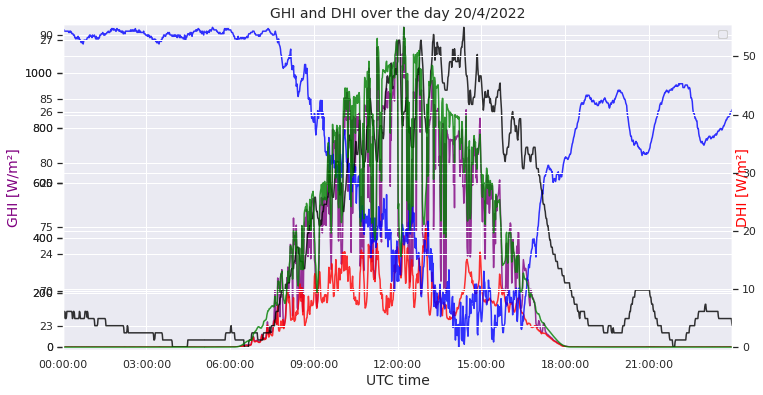

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
date = datetime.utcnow() 
YEAR = date.year
MONTH = date.month # MONTH format must be a two character string : 'xx'
#Now let get last date logged(yesterday date)
lastdate = datetime.now() + timedelta(days=-2)  
DAY=lastdate.day  # DAY format must be a two character string : 'xx'

# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]
RH = data['relative_humidity'][:]
Temp = data['air_temperature'][:]
UV = data['UV_irradiance_on_A_and_B_band'][:]

# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax2.twinx()
ax4 = ax3.twinx()
ax5 = ax4.twinx()



ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)
ax3.plot(T_dt, RH, c='blue', alpha = 0.8)
ax4.plot(T_dt, Temp, c='black', alpha = 0.8)
ax5.plot(T_dt, UV, c='green', alpha = 0.8)



ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

**Avec :**
> - GHI : purple
> - DHI : red
> - RH : blue
> - Temp : black
> - UV : green

###d- Sauvegarder les variables pour notre LSTM
Ici on va sauvegarder localement en sour forme de dictionnaire en format **.csv** les variables qui peuvent avoir des reletions direct pour la prévision de l'ensoillement, à savoir : 

> - GHI (global_horizontal_irradiance (W m-2))
> - DHI (diffuse_horizontal_irradiance (W m-2))
> - RH (relative_humidity (%RH))
> - Temp (air_temperature (degree Celsius))
> - UV (UV_irradiance_on_A_and_B_band (W m-2))

In [ ]:
import numpy as np
import pandas as pd

dic={'time':[],'GHI':[],'DHI':[],'RH':[],'Temp':[],'UV':[]}
years=[]
files=[]
dude='1572415339_2019-10-29.nc'
for i in range(2019,date.year+1):
  
  url=f'{tds_url}{COUNTRY}/{STATION}/{i}/catalog.xml'
  print("")
  print(f'> - Year {i}')

  print(f'Requesting {url} ...')

  cat = TDSCatalog(url)
  print(f'    -> Success')

  # Select the right file
  #Skipping the first file named "1572415339_2019-10-29.nc" as we have explained earler (contain to much NA values)
  selection = [d for d in cat.datasets[:] if '1572415339_2019-10-29' not in d.name]
  selection.reverse()
  print(f'Found {len(selection)} file(s) : {selection}')

  
  

  # Access the data
  print('Accessing file on server...')



> - Year 2019
Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2019/catalog.xml ...
    -> Success
Found 63 file(s) : [1572415339_2019-10-30.nc, 1572415339_2019-10-31.nc, 1572415339_2019-11-01.nc, 1572415339_2019-11-02.nc, 1572415339_2019-11-03.nc, 1572415339_2019-11-04.nc, 1572415339_2019-11-05.nc, 1572415339_2019-11-06.nc, 1572415339_2019-11-07.nc, 1572415339_2019-11-08.nc, 1572415339_2019-11-09.nc, 1572415339_2019-11-10.nc, 1572415339_2019-11-11.nc, 1572415339_2019-11-12.nc, 1572415339_2019-11-13.nc, 1572415339_2019-11-14.nc, 1572415339_2019-11-15.nc, 1572415339_2019-11-16.nc, 1572415339_2019-11-17.nc, 1572415339_2019-11-18.nc, 1572415339_2019-11-19.nc, 1572415339_2019-11-20.nc, 1572415339_2019-11-21.nc, 1572415339_2019-11-22.nc, 1572415339_2019-11-23.nc, 1572415339_2019-11-24.nc, 1572415339_2019-11-25.nc, 1572415339_2019-11-26.nc, 1572415339_2019-11-27.nc, 1572415339_2019-11-28.nc, 1572415339_2019-11-29.nc, 1572415339_2019-11-30.nc, 15724153

In [ ]:
import numpy as np
import pandas as pd

dic={'time':[],'GHI':[],'DHI':[],'RH':[],'Temp':[],'UV':[]}
years=[]
files=[]

for i in range(2019,date.year+1):
    
  url=f'{tds_url}{COUNTRY}/{STATION}/{i}/catalog.xml'
  print("-----------------------------------------------------------")
  print(f'> - Year {i}')

  print(f'Requesting {url} ...')

  cat = TDSCatalog(url)
  print(f'    -> Success')

  # Select the right file
  #Skipping the first file named "1572415339_2019-10-29.nc" as we have explained earler (contain to much NA values)
  selection = [d for d in cat.datasets[:] if '1572415339_2019-10-29' not in d.name]
  selection.reverse()
  print(f'Found {len(selection)} file(s) : {selection}')

  
  
  # Access the data
  print('Accessing file on server...')


  for files in selection:
  
    data = files.remote_access()
    print(f'   -> 1 Day file "{files}" Done')

    # save each netCDF files values inside 'dic' dictionnary for each .nc files(1440 values) and each year(2019-2022), and Convert unix time in a datetime format
    dic['time'].extend([ datetime.fromtimestamp(t) for t in data['time'][:]] )
    dic['GHI'].extend(data['total_horizontal_irradiance'][:])
    dic['DHI'].extend(data['diffuse_horizontal_irradiance'][:])
    dic['RH'].extend(data['relative_humidity'][:])
    dic['Temp'].extend(data['air_temperature'][:])
    dic['UV'].extend(data['UV_irradiance_on_A_and_B_band'][:])


    arr=data['total_horizontal_irradiance'][:]
    print(f'{len(arr)} values for variable "GDI" ')

    

  print(f'my_dict : {len(dic)}') 
  
 
  #convert dictionnary to dataframe
  df = pd.DataFrame(dic)
  
  #show dataframe for each files passed
  print(df)

#save dataframe to csv format
df.to_csv('iosnet_df.csv',index=False)

-----------------------------------------------------------
> - Year 2019
Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2019/catalog.xml ...
    -> Success
Found 63 file(s) : [1572415339_2019-10-30.nc, 1572415339_2019-10-31.nc, 1572415339_2019-11-01.nc, 1572415339_2019-11-02.nc, 1572415339_2019-11-03.nc, 1572415339_2019-11-04.nc, 1572415339_2019-11-05.nc, 1572415339_2019-11-06.nc, 1572415339_2019-11-07.nc, 1572415339_2019-11-08.nc, 1572415339_2019-11-09.nc, 1572415339_2019-11-10.nc, 1572415339_2019-11-11.nc, 1572415339_2019-11-12.nc, 1572415339_2019-11-13.nc, 1572415339_2019-11-14.nc, 1572415339_2019-11-15.nc, 1572415339_2019-11-16.nc, 1572415339_2019-11-17.nc, 1572415339_2019-11-18.nc, 1572415339_2019-11-19.nc, 1572415339_2019-11-20.nc, 1572415339_2019-11-21.nc, 1572415339_2019-11-22.nc, 1572415339_2019-11-23.nc, 1572415339_2019-11-24.nc, 1572415339_2019-11-25.nc, 1572415339_2019-11-26.nc, 1572415339_2019-11-27.nc, 1572415339_2019-11-28.nc, 1

#4) Preparation du dataset

###Importation des variables depuis le dataset csv precedement sauvegarder
"Cancel the upload process if file is already loaded"

In [ ]:
from google.colab import files

#Upload the csv file from pc(Juste cancel si on va pas improter depuis PC)
files.upload()

#Read the csv file
df = pd.read_csv('iosnet_df.csv')
df.head()

,time,GHI,DHI,RH,Temp,UV
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001


Creation des nouveaux variables :
> - date
> - year
> - day
> - jday (julian day 1 à 365/366 jours)
> - hour
> - minute

In [ ]:
df.head()

,time,GHI,DHI,RH,Temp,UV
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001


###Répartitionner la Date en year, month, day, minute

In [ ]:
df['time']=pd.to_datetime(df['time'])
df['date']=pd.to_datetime(df['time']).dt.date

df['year']=df['time'].apply(lambda x: x.year)
df['month']=df['time'].apply(lambda x: x.month)
df['day']=df['time'].apply(lambda x: x.day)
df['jday'] = df['time'].apply(lambda x: x.timetuple().tm_yday )
df['hour']=df['time'].apply(lambda x: x.hour)
df['minute']=df['time'].apply(lambda x: x.minute)

df.head()


,time,GHI,DHI,RH,Temp,UV,date,year,month,day,jday,hour,minute
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001,2019-10-30,2019,10,30,303,0,0
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001,2019-10-30,2019,10,30,303,0,1
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001,2019-10-30,2019,10,30,303,0,2
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001,2019-10-30,2019,10,30,303,0,3
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001,2019-10-30,2019,10,30,303,0,4


In [ ]:
df.tail()

,time,GHI,DHI,RH,Temp,UV,date,year,month,day,jday,hour,minute
1264315,2022-04-21 23:55:00,NaN,NaN,NaN,NaN,NaN,2022-04-21,2022,4,21,111,23,55
1264316,2022-04-21 23:56:00,NaN,NaN,NaN,NaN,NaN,2022-04-21,2022,4,21,111,23,56
1264317,2022-04-21 23:57:00,NaN,NaN,NaN,NaN,NaN,2022-04-21,2022,4,21,111,23,57
1264318,2022-04-21 23:58:00,NaN,NaN,NaN,NaN,NaN,2022-04-21,2022,4,21,111,23,58
1264319,2022-04-21 23:59:00,NaN,NaN,NaN,NaN,NaN,2022-04-21,2022,4,21,111,23,59


Verification **NA** value

In [ ]:
#find if there are some NA value in dataset
df['GHI'].isnull().sum()

3208

###Remplacer NAN value by 0

In [ ]:
df['GHI'] = df['GHI'].fillna(int(0)) 
df['DHI'] = df['DHI'].fillna(int(0)) 
df['RH'] = df['RH'].fillna(int(0)) 
df['Temp'] = df['Temp'].fillna(int(0)) 
df['UV'] = df['UV'].fillna(0) 

In [ ]:
df.tail()

,time,GHI,DHI,RH,Temp,UV,date,year,month,day,jday,hour,minute
1231195,2022-03-29 23:55:00,1.115,0.536,80.9,22.37,0.005,2022-03-29,2022,3,29,88,23,55
1231196,2022-03-29 23:56:00,1.197,0.532,80.8,22.40,0.005,2022-03-29,2022,3,29,88,23,56
1231197,2022-03-29 23:57:00,1.249,0.538,80.9,22.40,0.005,2022-03-29,2022,3,29,88,23,57
1231198,2022-03-29 23:58:00,1.497,0.546,80.9,22.33,0.005,2022-03-29,2022,3,29,88,23,58
1231199,2022-03-29 23:59:00,1.258,0.547,80.8,22.30,0.005,2022-03-29,2022,3,29,88,23,59


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231200 entries, 0 to 1231199
Data columns (total 13 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   time    1231200 non-null  datetime64[ns]
 1   GHI     1231200 non-null  float64       
 2   DHI     1231200 non-null  float64       
 3   RH      1231200 non-null  float64       
 4   Temp    1231200 non-null  float64       
 5   UV      1231200 non-null  object        
 6   date    1231200 non-null  object        
 7   year    1231200 non-null  int64         
 8   month   1231200 non-null  int64         
 9   day     1231200 non-null  int64         
 10  jday    1231200 non-null  int64         
 11  hour    1231200 non-null  int64         
 12  minute  1231200 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(6), object(2)
memory usage: 122.1+ MB


###Agreggation par jour avec un seul feature à l'entré
Comme on a des données séquentielles de chaque minutes depuis le serveur TDS de IOS-net, on va faire la moyenne pour obtenir des données plutot journalière.

Ici, on vas utilisé comme feature, le GHI à l'entré pour prédire une label GHI suivante à la sortie (une label GHI correspond à une prédiction d'une journé suivante)

In [ ]:
#Aggregation par date avec une seul feature à l'entré et une label à la sortie
df2 = df.groupby('date')['GHI'].mean()
print(df2)

date
2019-10-30    331.873003
2019-10-31    324.614169
2019-11-01    241.083911
2019-11-02    246.661104
2019-11-03    185.372197
                 ...    
2022-03-25    194.689736
2022-03-26    155.514372
2022-03-27    199.701943
2022-03-28    232.499305
2022-03-29    196.232533
Name: GHI, Length: 855, dtype: float64


### Import library and modules necessary for your descision tree forecasting

In [ ]:
from math import sqrt
from numpy import concatenate
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import tree
from matplotlib import pyplot

###  Convert series to supervised learning

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
			
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names

	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Dataset preparation

In [ ]:
df2.to_csv('df2.csv')

In [ ]:
# load dataset
#dataset = read_csv('df2.csv', header = 0, index_col=0)
dataset = read_csv('df2.csv')
dataset.head()


,date,GHI
0,2019-10-30,331.873003
1,2019-10-31,324.614169
2,2019-11-01,241.083911
3,2019-11-02,246.661104
4,2019-11-03,185.372197


### Convertir notre pandas dataframe vers numpy array

In [ ]:
np_date = dataset['date'].to_numpy()
np_GHI = dataset['GHI'].to_numpy()

In [ ]:
print(f'np_GHI : \n{np_GHI}')

### Convert GHI numpy float to numpy int 

In [ ]:
np_GHI = np_GHI.astype(int)
np_GHI

### Reshape for single feature

In [ ]:
np_GHI = np_GHI.reshape(-1, 1)
np_date = np_date.reshape(-1, 1)

np_GHI.shape,np_date.shape

((855, 1), (855, 1))

In [ ]:
# normalise features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(np_GHI)

# frame as supervised learning
n_mins = 7
n_features = 1
reframed = series_to_supervised(scaled, n_mins, 1)

print(reframed.shape)


(848, 8)


### Split into train and test sets

In [ ]:
# split into train and test sets, such as train 85%
values = reframed.values

n_train_mins = int(len(values)*85/100)
train = values[:n_train_mins, :]
test = values[n_train_mins:, :]

#Split date into test and train sets


# split into input and outputs
n_obs = n_mins * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X,  test_y =test[:, :n_obs], test[:,-1]

print(train_y,test_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


###Dimension 

In [ ]:
date.ndim

2

###Convert date 2D to 1D

In [ ]:
date= date.reshape(date.shape[0],)
date.shape

(128,)

In [ ]:
date.ndim

1

### Design Decision Trees model

In [ ]:
# design DTs model
clf = tree.DecisionTreeRegressor()

# fit model
clf.fit(train_X,train_y)

DecisionTreeRegressor()

### Make a prediction

In [ ]:
#we got 1D array
predict_y = clf.predict(test_X)

#Convert predict 1D to 2D array
yhat = predict_y.reshape(predict_y.shape[0],1)

test_X = test_X.reshape((test_X.shape[0],n_mins*n_features))
print(yhat.shape,test_X.shape)

predict_y before : ((128,), 1)
predict_y after : ((128, 1), 2)
test_X : (128, 7)
test_X2 : (128, 7)
(128, 1) (128, 7)


In [ ]:
regressor.save('models/model0.h5')

### Invert scaling for forecast

In [ ]:
inv_yhat = concatenate((test_X[:, -24:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

### Invert scaling for actual

In [ ]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -24:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [ ]:
y_pred = inv_yhat[:]
y_true = inv_y[:]

# V Test performance du model

### Bias
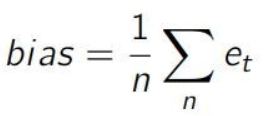

avec:

Forecast error

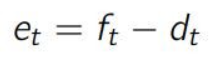

In [ ]:
bias = (y_true - y_pred).mean()
print(f'Bias : {bias :.4f}')

Bias : 13.8203


###Calculate RMSE (Root Mean Square Error)
Mesure permetant de determiner la diffence entre d'ecart notre valeur predit et valeur observer sur notre model.

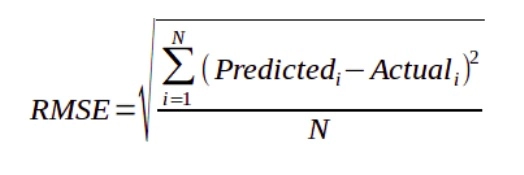

#### Using sklearn

In [ ]:
import sklearn
import math
from sklearn.metrics import mean_squared_error
mse = sklearn.metrics.mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)

RMSE :  40.46%


In [ ]:
rmse

#### Using formulla

In [ ]:
rmse = sqrt(mean_squared_error(y_true, y_pred))
print('Test RMSE: %.3f' % rmse)

### Calculate MAPE ( Mean Absolute Percentage Error )
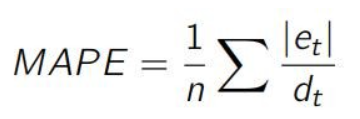

avec :

Forecast error

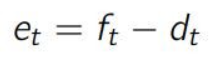

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_y,predict_y)
print(f'Test mape: {mape : .2f}')

Test mape:  49.18%


### Calculate MAE (Mean Absolute Error)
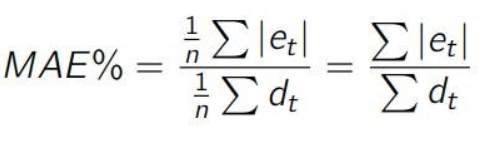

### Do some prediction to try out our model

In [ ]:
index = [0, len(test_y)//8, len(test_y)//5, len(test_y)//4, len(test_y)//2, len(test_y)-1]
for i in index:
	print(f'{date[i]} : y = {int(inv_y[i])} => yhat= {int(inv_yhat[i])}')


2021-10-26 : y = 260 => yhat= 208
2021-11-11 : y = 297 => yhat= 149
2021-11-20 : y = 282 => yhat= 268
2021-11-27 : y = 194 => yhat= 170
2021-12-29 : y = 305 => yhat= 90
2022-03-29 : y = 195 => yhat= 129


In [ ]:
inv_y[:].shape, inv_yhat[:].shape, test_y.shape

((128,), (128,), (128, 1))

#Sauvegarder notre model 

### Save model

In [ ]:
from joblib import dump, load
dump(clf, 'DHI_dtrees.joblib')

['DHI_dtrees.joblib']

###Load model

In [ ]:
clf_file = load('DHI_dtrees.joblib')

###Make prediction on our test_X set

In [ ]:
#we got 1D array
predict_y = clf_file.predict(test_X)
#Convert predict 1D to 2D array
yhat = predict_y.reshape(predict_y.shape[0],1)
test_X = test_X.reshape((test_X.shape[0],n_mins*n_features))


###Reverse scaling 

Reverse the prediction array

In [ ]:
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat = inv_yhat[:,-1]

Reverse test set array

In [ ]:
inv_y = scaler.inverse_transform(test_y)
inv_y = inv_y[:,-1]

###Show some part of our prediction

In [ ]:
index = [0, len(test_y)//8, len(test_y)//5, len(test_y)//4, len(test_y)//2, len(test_y)-1]
for i in index:
	print(f'{date[i]} : y = {int(inv_y[i])} => yhat= {int(inv_yhat[i])}')

2021-10-26 : y = 260 => yhat= 208
2021-11-11 : y = 297 => yhat= 149
2021-11-20 : y = 282 => yhat= 268
2021-11-27 : y = 194 => yhat= 170
2021-12-29 : y = 305 => yhat= 90
2022-03-29 : y = 195 => yhat= 129


### Plot

In [ ]:
inv_y[:].shape

(128,)

In [ ]:
inv_yhat[:].shape

(128,)

In [ ]:
date.ndim

1

In [ ]:
print([i for i in date])


['2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29', '2021-10-30', '2021-10-31', '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05', '2021-11-06', '2021-11-07', '2021-11-08', '2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12', '2021-11-13', '2021-11-14', '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22', '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26', '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30', '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04', '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08', '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12', '2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20', '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31', '2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022

### Plot date

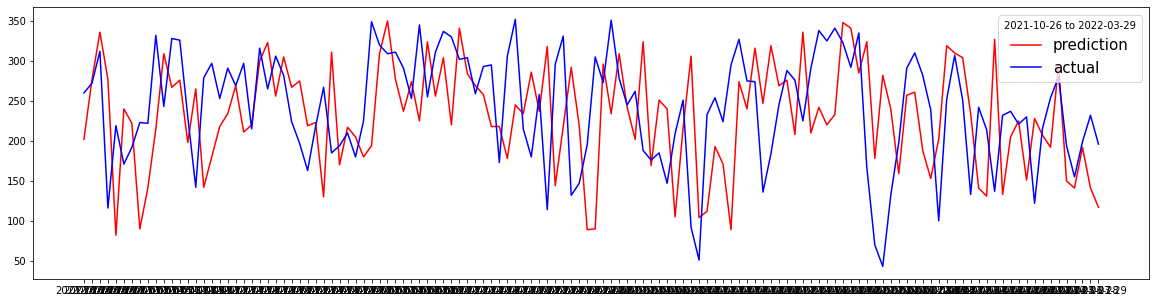

In [ ]:
#plt.rcParams["figure.figsize"] = (20,5)
pyplot.plot([x for x in date], inv_yhat, linestyle='-', color='red', label='prediction')
pyplot.plot([i for i in date], inv_y, linestyle='-', color='blue', label=f'actual') #\n from {date[0]} \n to{date[-1]}

pyplot.legend(loc=1, prop={'size': 15}, title=f"{date[0]} to {date[-1]}",fontsize='small')
pyplot.show()

###Plot by number

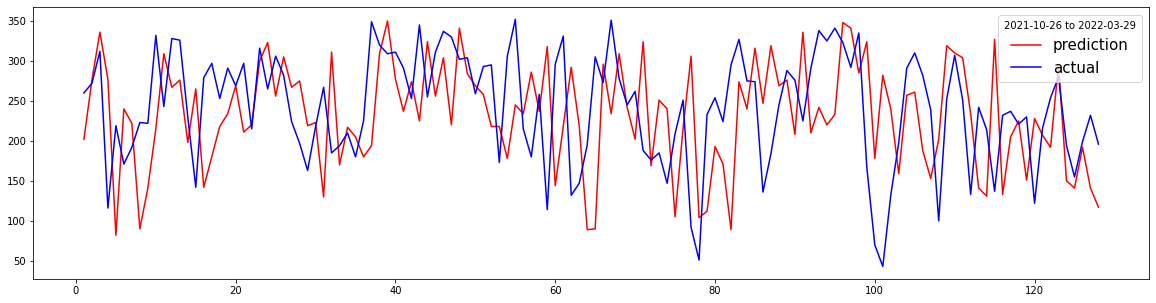

In [ ]:
# plot 
from matplotlib import pyplot

plt.rcParams["figure.figsize"] = (20,5)
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='-', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12}, title=f"{date[0]} to {date[-1]}",fontsize='small')
pyplot.show()